# Create HTML dashboard

In [31]:
import polars as pl
import numpy as np

In [33]:
# READ WELSH
welsh = pl.read_parquet("s3://dandelion-clinical-data/welsh/platinum/cropped_baseline_minmax/")
acp = pl.read_parquet("s3://dandelion-clinical-data/acp/platinum/recalibrated_baseline_minmax_interpolated/")

In [42]:
acp

Cohort,Plate Number,Well,Sample ID,SAM,p,r,z,t,s,label,500.33,503.62,506.92,510.22,513.51,516.80,520.08,523.35,526.63,529.91,533.18,536.45,539.71,542.97,546.23,549.48,552.74,555.99,559.24,562.49,565.72,568.96,572.19,575.42,578.64,581.86,…,2541.99,2543.60,2545.20,2546.80,2548.41,2550.01,2551.61,2553.22,2554.82,2556.41,2558.01,2559.61,2561.20,2562.79,2564.38,2565.98,2567.56,2569.15,2570.73,2572.33,2573.91,2575.50,2577.08,2578.66,2580.24,2581.82,2583.39,2584.97,2586.55,2588.13,2589.70,2591.28,2592.84,2594.42,2595.98,2597.55,2599.12
str,i32,str,str,i32,i64,i64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""ACP""",4,"""D10""","""ACP - AC000148""",7,0,0,-7.29192,-59.46,0.5,"""Control""",0.0,0.035832,0.050616,0.056349,0.052437,0.042617,0.028812,0.019628,0.014696,0.012722,0.009864,0.012727,0.01593,0.024205,0.03596,0.055836,0.085558,0.103467,0.089819,0.056472,0.024399,0.009522,0.003979,0.003292,0.000927,0.001494,…,0.003509,0.00362,0.002782,0.00261,0.002816,0.002558,0.003178,0.002087,0.002472,0.001546,0.001759,0.001664,0.002149,0.002616,0.002803,0.00234,0.002509,0.001868,0.002901,0.002911,0.003213,0.002754,0.002335,0.003082,0.002452,0.002774,0.002591,0.001864,0.001716,0.001586,0.002296,0.001275,0.001812,0.002212,0.000973,0.001657,0.0
"""ACP""",13,"""D11""","""ACP - AC000148""",9,0,0,-7.45109,-59.46,0.5,"""Control""",0.0,0.0306,0.029255,0.019903,0.011232,0.005309,0.002585,0.001391,0.00123,0.001197,0.000896,0.001287,0.001943,0.001925,0.001314,0.001003,0.000772,0.000849,0.000362,0.000311,0.000435,0.00036,0.000547,0.000447,0.000574,0.000763,…,0.001747,0.00157,0.00179,0.001906,0.001727,0.00192,0.001888,0.001741,0.00166,0.001552,0.001525,0.001455,0.001294,0.001433,0.001128,0.001171,0.001146,0.001113,0.000983,0.001103,0.000791,0.00093,0.000863,0.000926,0.000737,0.000729,0.000708,0.000732,0.000667,0.000537,0.000443,0.000383,0.000536,0.000417,0.000276,0.000448,0.0
"""ACP""",1,"""D10""","""ACP - AC000148""",6,0,0,-7.02331,-59.46,0.5,"""Control""",0.0,0.029884,0.04952,0.079286,0.121645,0.17748,0.231987,0.269868,0.27252,0.231623,0.169047,0.111704,0.06979,0.043076,0.028342,0.020594,0.01666,0.013278,0.010084,0.007762,0.005489,0.004055,0.003907,0.003172,0.00171,0.000632,…,0.001592,0.001922,0.002595,0.002469,0.002267,0.001954,0.002003,0.002496,0.002622,0.002324,0.002517,0.002194,0.002066,0.001885,0.001883,0.00166,0.002018,0.0022,0.001749,0.001698,0.001737,0.002086,0.002171,0.002241,0.002129,0.002154,0.001472,0.001877,0.00181,0.001625,0.001633,0.001542,0.00112,0.001483,0.001668,0.000525,0.0
"""ACP""",7,"""D10""","""ACP - AC000148""",8,0,0,-7.25361,-59.46,0.5,"""Control""",0.0,0.022265,0.038633,0.051166,0.051957,0.040988,0.026656,0.015495,0.009212,0.005501,0.004764,0.005259,0.006054,0.006264,0.006233,0.005202,0.005084,0.005101,0.004627,0.005329,0.005484,0.005419,0.005331,0.004932,0.004045,0.003238,…,0.00151,0.001952,0.001555,0.001702,0.001647,0.001366,0.001442,0.001092,0.001161,0.000968,0.000892,0.001463,0.001038,0.000953,0.000937,0.00096,0.001054,0.001215,0.001368,0.001632,0.00135,0.001561,0.001248,0.001305,0.001569,0.001073,0.001316,0.000956,0.001273,0.001011,0.001025,0.000723,0.000683,0.000745,0.000459,0.00082,0.0
"""ACP""",10,"""D10""","""ACP - AC000148""",10,0,0,-7.15264,-59.46,1.0,"""Control""",0.0,0.001169,0.001033,0.00081,0.000415,0.000936,0.001153,0.001321,0.002323,0.00276,0.003327,0.005378,0.00886,0.017484,0.029865,0.037705,0.034163,0.023732,0.015331,0.012902,0.015213,0.025639,0.050919,0.10971,0.20558,0.293176,…,0.00368,0.00415,0.004121,0.004455,0.004196,0.004084,0.003915,0.003628,0.00347,0.003029,0.002768,0.002618,0.002337,0.002581,0.002219,0.002075,0.001888,0.002085,0.001804,0.002155,0.002237,0.002043,0.001567,0.001859,0.00156,0.001606,0.001328,0.001305,0.000778,0.001104,0.000651,0.000953,0.000787,0.000337,0.000405,0.000

In [63]:
def prepare_agg(data, sam, spectrum_columns):
    df = (
        data
        .select(["SAM", "label"] + spectrum_columns)
        .filter(pl.col("SAM") == sam)
        .group_by("SAM", "label")
        .agg([
            *[pl.col(col).mean().alias(f"avg_{col}") for col in spectrum_columns],
            *[pl.col(col).std().alias(f"std_{col}") for col in spectrum_columns],
        ])
    ).to_pandas()

    avg_cols = [col for col in df.columns if col.startswith("avg_")]
    std_cols = [col for col in df.columns if col.startswith("std_")]

    avg_long = df.melt(id_vars=["SAM", "label"], value_vars=avg_cols, var_name="Raman_Shift", value_name="Avg_Intensity")
    std_long = df.melt(id_vars=["SAM", "label"], value_vars=std_cols, var_name="Raman_Shift", value_name="Std_Intensity")
    avg_long["Raman_Shift"] = avg_long["Raman_Shift"].str.replace("avg_", "").astype(float)
    std_long["Raman_Shift"] = std_long["Raman_Shift"].str.replace("std_", "").astype(float)
    spectra_long = avg_long.merge(std_long, on=["SAM", "label", "Raman_Shift"])
    
    return spectra_long

In [105]:
# Base accent color from your UI
palette = ['#3885df', '#e1b74a', '#5b69e4', '#dde76d', '#6338df', '#9fe14a', '#b05be4', '#85e76d',
           '#db38df', '#4ae162', '#e45bb6', '#6de7ac', '#df386a', '#4ae1cf', '#e4635b', '#6dcae7', '#df7e38',
           '#4a86e1', '#e4c65b', '#6d72e7']

In [163]:
import plotly.graph_objects as go
import matplotlib.colors as mcolors

def color_to_rgba(color_name: str, alpha: float = 0.3) -> str:
    r, g, b = mcolors.to_rgb(color_name)
    return f'rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {alpha})'

def plot2mean_interactive(sam: str, data: list, data_labels: list, spectrum_columns, colors: list = palette):
    
    fig = go.Figure()
    n = -1
    for i in range(len(data)):
        spectra = prepare_agg(data[i], sam, spectrum_columns)

        for label in spectra["label"].unique():
            n +=1
            subset = spectra[spectra["label"] == label]
        
            fig.add_trace(go.Scatter(
                x=subset["Raman_Shift"],
                y=subset["Avg_Intensity"],
                mode='lines',
                name=f"{data_labels[i]} - {label} mean",
                line=dict(color=colors[n]),
                visible="legendonly" if i>0 else None # default to show traces of the first data and toggle the rest 
            ))
        
            lower = (subset["Avg_Intensity"] - subset["Std_Intensity"]).clip(lower=0)
            upper = (subset["Avg_Intensity"] + subset["Std_Intensity"])
        
            fig.add_trace(go.Scatter(
                x=subset["Raman_Shift"],
                y=upper,
                mode='lines',
                line=dict(width=0),
                showlegend=False
            ))
    
            fig.add_trace(go.Scatter(
                x=subset["Raman_Shift"],
                y=lower,
                fill='tonexty',
                mode='lines',
                line=dict(width=0),
                fillcolor = color_to_rgba(colors[n], 0.3),
                name=f"{data_labels[i]} - {label} std dev.",
                visible="legendonly"
            ))

    
    fig.update_layout(
        title=f"SAM {sam} (Mean ± SD)",
        xaxis_title="Raman Shift [cm⁻¹]",
        yaxis_title="Avg Intensity",
        hovermode='x unified',
        template="plotly_white",
        height=600,
        width=1000
    )

    return fig
    fig.show()


In [164]:
figs = []
unique_sams = acp.select("SAM").unique().to_numpy().flatten()
spectrum_columns = acp.columns[13:]

for sam in np.sort(unique_sams):
    figs.append(plot2mean_interactive(sam, data=[welsh, acp], data_labels=["WELSH", "ACP"], spectrum_columns=spectrum_columns))

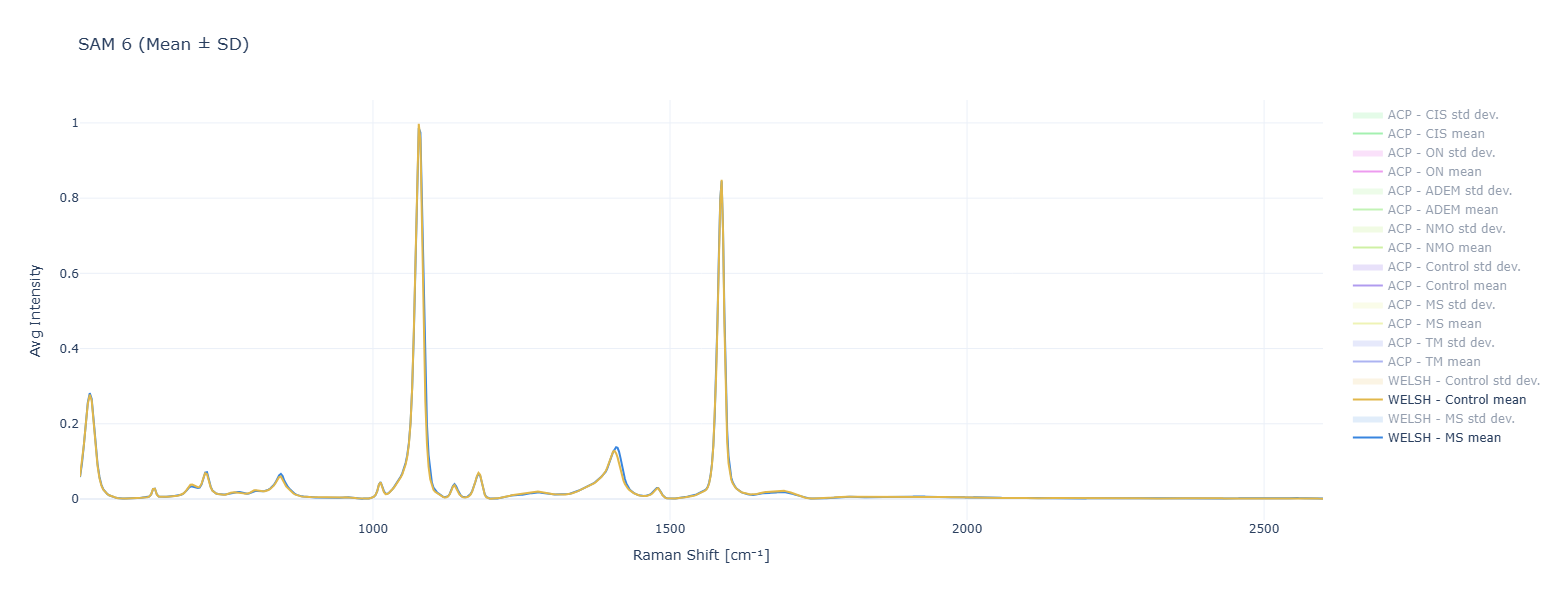

In [165]:
figs[0]

In [178]:
full_html = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>All Raman Plots</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            background-color: #f8f9fa;
            color: #333;
            line-height: 1.6;
            margin: 0;
            padding: 20px;
            display: flex;
            justify-content: center;
        }
        .container {
            max-width: 1100px;
            width: 100%;
            text-align: center;
        }
        header {
            background-color: #481F70;
            color: white;
            padding: 15px 20px;
            border-radius: 8px;
            margin-bottom: 20px;
        }
        header h1 {
            margin: 0;
            font-size: 1.5rem;
        }
        section {
            background: white;
            border-radius: 8px;
            padding: 20px;
            box-shadow: 0 2px 8px rgba(0,0,0,0.05);
        }
        h2 {
            color: #4a90e2;
            margin-top: 0;
        }
        ul {
            padding-left: 20px;
            text-align: left; /* Keep bullet lists aligned nicely */
        }
        code {
            background: #f1f1f1;
            padding: 2px 6px;
            border-radius: 4px;
            font-family: monospace;
            font-size: 0.95rem;
        }
        .image-section {
        display: flex;
        flex-direction: column;  /* stack vertically */
        justify-content: center; /* center horizontally */
        align-items: center;     /* center horizontally */
        gap: 20px;               /* space between images */
      }
    
        .image-section img {
        max-width: 100%;
        height: auto;
        border-radius: 6px;
    }
    </style>
</head>
<body>
    <div class="container">
        <header>
            <h1>Dandelion DX dashboard</h1>
        </header>

        <section>
            <h2>Data Considerations</h2>
            <ul>
                <li>20 random ACP samples from each diagnosis were used, for the sake of computing power.</li>
                <li>The processing pipeline was the following:
                    <ul>
                        <li>Cut x-axis <code>[500, 2600]</code></li>
                        <li><code>rp.preprocessing.baseline.IASLS(diff_order=3)</code></li>
                        <li><code>rp.preprocessing.normalise.MinMax()</code></li>
                    </ul>
                </li>
                <li>The plots show the average and standard deviation between all samples, 3 replicates (<code>r</code>) and 3 points (<code>p</code>).</li>
            </ul>
        </section>
        
"""

In [179]:
import plotly.io as pio

html_list = [pio.to_html(fig, include_plotlyjs='cdn' if i == 0 else False, full_html=False) 
             for i, fig in enumerate(figs)]
print(len(html_list))

# Add each HTML plot block to the body
for i, plot_html in enumerate(html_list, start=1):
    full_html += '<section class="image-section">'
    full_html += plot_html
    full_html += "</section>"

# Close HTML
full_html += """
    </div>
</body>
</html>
"""

with open("sams_ACP_WELSH_interactive.html", "w") as f:
    f.write(full_html)

5
